# General Mixture Models

author: Jacob Schreiber <br>
contact: jmschreiber91@gmail.com

It is frequently the case that the data you have is not explained by a single underlying distribution. If we want to try to recover the underlying distributions, we need to have a model which has multiple components. An example is the following data.

In [62]:
from pomegranate import *
%pylab inline
import numpy as np

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


(array([   4.,    7.,    9.,   17.,   17.,   27.,   30.,   29.,   23.,
          24.,   22.,   17.,   15.,   39.,  100.,  140.,  122.,   73.,
          29.,    6.]),
 array([ -5.56573751,  -4.71804098,  -3.87034445,  -3.02264792,
         -2.17495139,  -1.32725486,  -0.47955833,   0.36813819,
          1.21583472,   2.06353125,   2.91122778,   3.75892431,
          4.60662084,   5.45431737,   6.3020139 ,   7.14971043,
          7.99740696,   8.84510349,   9.69280002,  10.54049655,  11.38819308]),
 <a list of 20 Patch objects>)

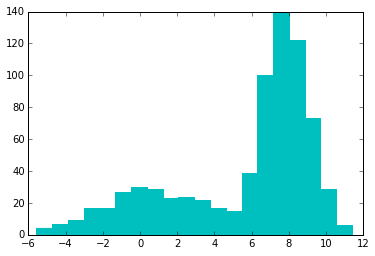

In [63]:
data = np.concatenate( (np.random.randn(250) * 2.75 + 1.25, np.random.randn(500) * 1.2 + 7.85) )
np.random.shuffle(data)
plt.hist( data, edgecolor='c', color='c', bins=20 )

We can create our initial estimate of what this distribution is a General Mixture Model. This is a model which is comprised of multiple distributions, and weights on those distributions representing the prior probability of a point falling under that distribution given no knowledge of the point itself (defaults to equal). We can have univariate mixture models by using univariate distributions, or multivariate distributions by using multivariate distributions.

In [64]:
d = GeneralMixtureModel( [NormalDistribution(2.5, 1), NormalDistribution(8, 1)] )

We can now predict the class labels of each point under this mixture. 

In [65]:
labels = d.predict( data )
print labels[:5]
print "{} 1 labels, {} 0 labels".format( labels.sum(), labels.shape[0] - labels.sum() )

[0 1 1 0 1]
515 1 labels, 235 0 labels


This is fairly close to the number of underlying points from each distribution, off by 17 in each label. We still don't know if the labels are accurate, just the number of labels.

(array([  9.,  14.,  17.,  20.,  47.,  33.,  49.,  55.,  45.,  42.,  47.,
         39.,  34.,  21.,  14.,  13.,   9.,   4.,   0.,   3.]),
 array([  5.26562359,   5.57175207,   5.87788054,   6.18400902,
          6.49013749,   6.79626596,   7.10239444,   7.40852291,
          7.71465139,   8.02077986,   8.32690833,   8.63303681,
          8.93916528,   9.24529376,   9.55142223,   9.85755071,
         10.16367918,  10.46980765,  10.77593613,  11.0820646 ,  11.38819308]),
 <a list of 20 Patch objects>)

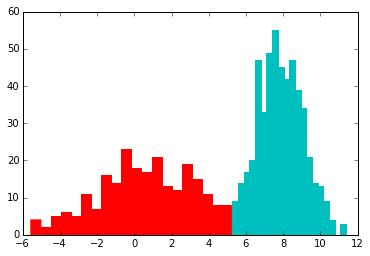

In [66]:
plt.hist( data[ labels == 0 ], edgecolor='r', color='r', bins=20 )
plt.hist( data[ labels == 1 ], edgecolor='c', color='c', bins=20 )

It is slightly more difficult to update the underlying components of the model because we don't have labels indicating which point came from which distribution. We could try to use the labels inferred from the model. It seems to cleanly split it, but what if our initial estimate was not very good? It could be difficult to get a good update if we had a bad prior. 

Another possibility is to predict the probability of each point under each component, to get a softer estimate of the labels. Lets take a look.

In [67]:
labels = d.predict_proba( data )
print labels[:5]
print labels.sum(axis=0)

[[  1.00000000e+00   1.02552840e-21]
 [  2.86349996e-10   1.00000000e+00]
 [  1.71616221e-05   9.99982838e-01]
 [  1.00000000e+00   3.82215263e-14]
 [  3.00125160e-15   1.00000000e+00]]
[ 237.56873233  512.43126767]


This is slightly closer to the truth, with 15.2 off instead of 17, around 10% closer.

This is the beginning of a common unsupervised training algorithm called <b>expectation maximization</b>. It has two steps, <b>expectation</b> and <b>maximization</b>. The <b>expectation</b> step involves what we just did--assigning weights based on the probability of each point being generated by each component. The next step, <b>maximization</b>, is maximizing the probability that the distribution generated these points but performing weighted MLE.

This process must be iterated until convergence. Sometimes this requires only a single update, but for overlapping distributions (such as this one) it can sometimes take many iterations.

In [68]:
d.fit( data, verbose=True )

Improvement: 929.870988278
Improvement: 0.793613085689
Improvement: 0.0390630757033


930.7036644389814

We can do the same with multivariate distributions just as easily.

In [69]:
mu = np.arange(5)
cov = np.eye(5)

mgs = [ MultivariateGaussianDistribution( mu*i, cov ) for i in range(5) ]
gmm = GeneralMixtureModel( mgs )

In [70]:
data = numpy.random.randn(1000, 5) * 5
for i in range(5):
    data[i::5] += np.arange(5)*i

Lets see how well some points fit under the mixture model.

In [71]:
for i in range(10):
    print "Point {}: logp {}".format( i, gmm.log_probability(data[i]) )

Point 0: logp -22.6332553344
Point 1: logp -25.9076074443
Point 2: logp -93.5137069248
Point 3: logp -36.2767042387
Point 4: logp -177.542691364
Point 5: logp -9.84077727966
Point 6: logp -57.4970262303
Point 7: logp -24.8740282638
Point 8: logp -50.279158487
Point 9: logp -71.0055567739


In [72]:
gmm.fit(data, verbose=True, stop_threshold=1)

Improvement: 44281.8637367
Improvement: 25.8081974947
Improvement: 8.91739135662
Improvement: 4.63647758262
Improvement: 2.94454867813
Improvement: 2.12090878237
Improvement: 1.64581922213
Improvement: 1.31504953439
Improvement: 1.0476410205
Improvement: 0.821552703599


44331.121323121726

Now lets see how well the previous points fit.

In [73]:
for i in range(10):
    print "Point {}: logp {}".format( i, gmm.log_probability(data[i]) )

Point 0: logp -14.5431093711
Point 1: logp -13.7876004845
Point 2: logp -16.3978128785
Point 3: logp -14.4055101426
Point 4: logp -19.6070018916
Point 5: logp -13.8939861845
Point 6: logp -15.1630366218
Point 7: logp -14.3881894407
Point 8: logp -15.2537383027
Point 9: logp -16.6332977265


Looks like they're being fit significantly better than before! Training works.